# Diabetic Retinopathy Detection using Deep Learning

## Project Overview
This notebook implements a **deep learning pipeline** for classifying retinal fundus images into 5 severity levels of Diabetic Retinopathy (DR):

| Class | Severity Level | Description |
|-------|---------------|-------------|
| 0 | **No_DR** | No diabetic retinopathy |
| 1 | **Mild** | Mild non-proliferative DR |
| 2 | **Moderate** | Moderate non-proliferative DR |
| 3 | **Severe** | Severe non-proliferative DR |
| 4 | **Proliferative** | Proliferative DR |

### Approach
- **Model**: ResNet50 (ImageNet pre-trained) with custom classification head
- **Training Strategy**: 2-Phase Transfer Learning
  - **Phase 1** (Epochs 1-10): Frozen backbone, train classifier only
  - **Phase 2** (Epochs 11-20): Fine-tune backbone layers 3 & 4
- **Dataset**: 35,126 retinal fundus images
- **Hardware**: NVIDIA RTX 3050 Laptop GPU (CUDA 12.1)
- **Framework**: PyTorch 2.5.1

---

## 1. Import Required Libraries

In [8]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

# Scikit-learn
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score, f1_score
)
from sklearn.preprocessing import label_binarize

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Python Version  : {sys.version}")
print(f"PyTorch Version : {torch.__version__}")
print(f"CUDA Available  : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device      : {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory      : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Python Version  : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version : 2.9.0+cpu
CUDA Available  : False


## 2. Configuration & Hyperparameters

In [ ]:
# ======================================================
# Paths
# ======================================================
BASE_DIR = r"c:\Users\ANNAMAYA\Desktop\Computer Science\Diabetic"
DATA_DIR = os.path.join(BASE_DIR, "data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")
MODEL_DIR = os.path.join(BASE_DIR, "saved_models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# ======================================================
# Image Settings
# ======================================================
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# ======================================================
# Class Labels (DR Severity)
# ======================================================
CLASS_NAMES = ["No_DR", "Mild", "Moderate", "Severe", "Proliferative"]
NUM_CLASSES = len(CLASS_NAMES)

# ======================================================
# Training Hyperparameters
# ======================================================
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10          # Frozen backbone
EPOCHS_PHASE2 = 10          # Fine-tuning
TOTAL_EPOCHS = EPOCHS_PHASE1 + EPOCHS_PHASE2
LEARNING_RATE_P1 = 1e-4     # Phase 1 LR
LEARNING_RATE_P2 = 1e-5     # Phase 2 LR (lower for fine-tuning)
DROPOUT_RATE = 0.4
EARLY_STOP_PATIENCE = 5

# ======================================================
# Model
# ======================================================
MODEL_BACKBONE = "ResNet50"
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_dr_model.pth")
FINAL_MODEL_PATH = os.path.join(MODEL_DIR, "DR_ResNet50_Final_Model.pth")

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 55)
print("  DIABETIC RETINOPATHY DETECTION - CONFIGURATION")
print("=" * 55)
print(f"  Device         : {DEVICE}")
print(f"  Model          : {MODEL_BACKBONE}")
print(f"  Image Size     : {IMG_SIZE}")
print(f"  Batch Size     : {BATCH_SIZE}")
print(f"  Total Epochs   : {TOTAL_EPOCHS} (P1:{EPOCHS_PHASE1} + P2:{EPOCHS_PHASE2})")
print(f"  LR Phase 1     : {LEARNING_RATE_P1}")
print(f"  LR Phase 2     : {LEARNING_RATE_P2}")
print(f"  Dropout        : {DROPOUT_RATE}")
print(f"  Num Classes    : {NUM_CLASSES}")
print(f"  Classes        : {CLASS_NAMES}")
print("=" * 55)

  DIABETIC RETINOPATHY DETECTION - CONFIGURATION
  Device         : cpu
  Model          : ResNet50
  Image Size     : (224, 224)
  Batch Size     : 32
  Total Epochs   : 20 (P1:10 + P2:10)
  LR Phase 1     : 0.0001
  LR Phase 2     : 1e-05
  Dropout        : 0.4
  Num Classes    : 5
  Classes        : ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']


## 3. Load and Preprocess Dataset

### Data Transforms
- **Training**: Augmentation (flip, rotation, affine, color jitter) + ImageNet normalization
- **Validation/Test**: Resize + ImageNet normalization only

In [ ]:
# ======================================================
# Data Transforms
# ======================================================
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ======================================================
# Load Datasets
# ======================================================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=0, pin_memory=True)

print(f"[OK] Training samples   : {len(train_dataset):,}")
print(f"[OK] Validation samples : {len(val_dataset):,}")
print(f"[OK] Test samples       : {len(test_dataset):,}")
print(f"\nClasses found: {train_dataset.classes}")
print(f"Class-to-index: {train_dataset.class_to_idx}")

In [ ]:
# ======================================================
# Dataset Class Distribution
# ======================================================
train_targets = [s[1] for s in train_dataset.samples]
class_counts = Counter(train_targets)
class_names_sorted = [CLASS_NAMES[i] for i in sorted(class_counts.keys())]
counts_sorted = [class_counts[i] for i in sorted(class_counts.keys())]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']
bars = axes[0].bar(class_names_sorted, counts_sorted, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title("Training Set -- Class Distribution", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Number of Images")
axes[0].set_xlabel("DR Severity")
for bar, count in zip(bars, counts_sorted):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 f'{count:,}', ha='center', fontsize=10, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart
axes[1].pie(counts_sorted, labels=class_names_sorted, colors=colors,
            autopct='%1.1f%%', startangle=90, pctdistance=0.85,
            explode=(0.05, 0.05, 0.05, 0.05, 0.05))
axes[1].set_title("Class Proportion", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass Distribution Summary:")
total = sum(counts_sorted)
for name, count in zip(class_names_sorted, counts_sorted):
    pct = count / total * 100
    print(f"   {name:15s} : {count:6,} images ({pct:5.1f}%)")

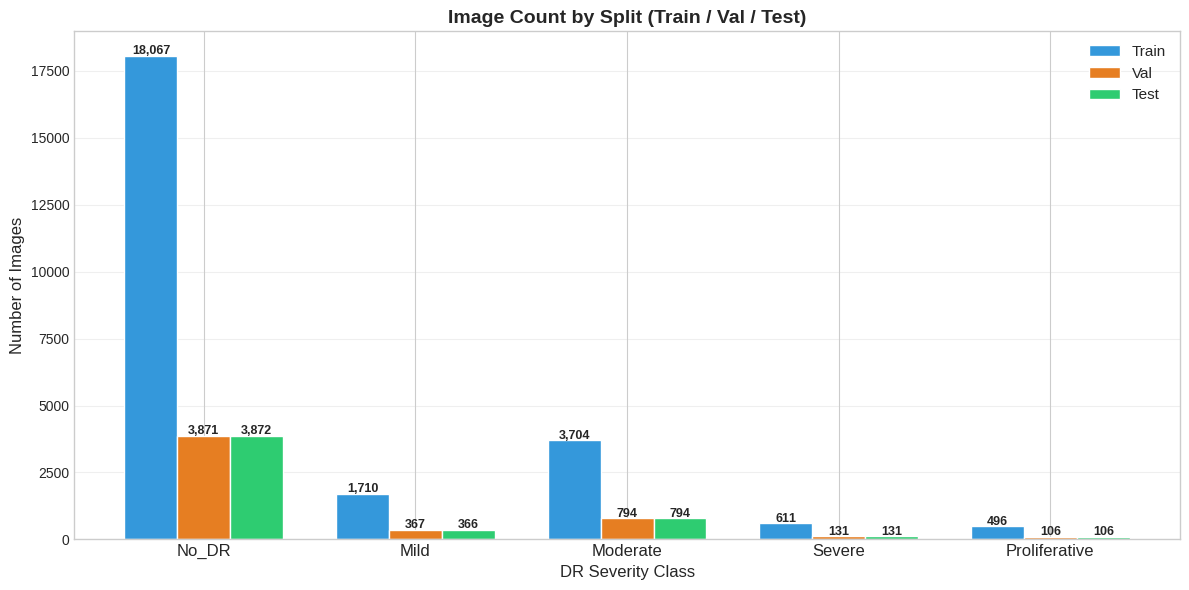

In [20]:
# ======================================================
# Number of Images per DR Type (Train / Val / Test)
# ======================================================
import matplotlib.pyplot as plt
import numpy as np

CLASS_NAMES_LOCAL = ["No_DR", "Mild", "Moderate", "Severe", "Proliferative"]
splits = ["train", "val", "test"]
colors_split = ['#3498db', '#e67e22', '#2ecc71']

# Actual image counts from the dataset
counts = {
    "train": [18067, 1710, 3704,  611,  496],
    "val":   [ 3871,  367,  794,  131,  106],
    "test":  [ 3872,  366,  794,  131,  106],
}

# ---- Chart 1: Grouped Bar Chart (Train / Val / Test) ----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(CLASS_NAMES_LOCAL))
width = 0.25

for i, (s, color) in enumerate(zip(splits, colors_split)):
    bars = ax.bar(x + i * width, counts[s], width, label=s.capitalize(),
                  color=color, edgecolor='white', linewidth=1)
    for bar, val in zip(bars, counts[s]):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                    f'{val:,}', ha='center', fontsize=9, fontweight='bold')

ax.set_xticks(x + width)
ax.set_xticklabels(CLASS_NAMES_LOCAL, fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.set_xlabel("DR Severity Class", fontsize=12)
ax.set_title("Image Count by Split (Train / Val / Test)", fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

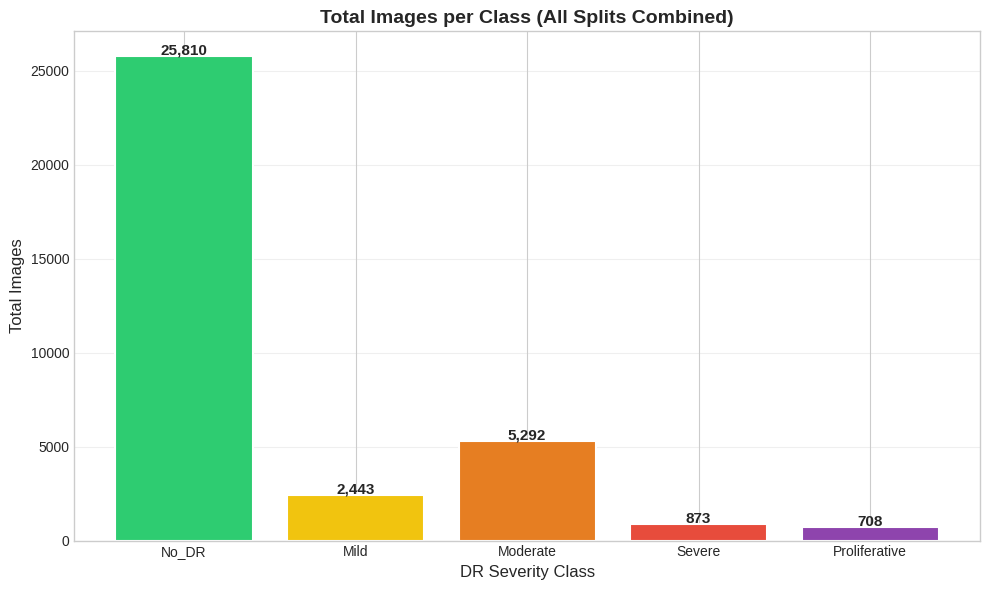


Class             Train     Val    Test   Total       %
-------------------------------------------------------
No_DR            18,067   3,871   3,872  25,810   73.5%
Mild              1,710     367     366   2,443    7.0%
Moderate          3,704     794     794   5,292   15.1%
Severe              611     131     131     873    2.5%
Proliferative       496     106     106     708    2.0%
-------------------------------------------------------
TOTAL            24,588   5,269   5,269  35,126  100.0%


In [21]:
# ---- Chart 2: Total Images per Class (All Splits) ----
totals = [sum(counts[s][i] for s in splits) for i in range(len(CLASS_NAMES_LOCAL))]
bar_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(CLASS_NAMES_LOCAL, totals, color=bar_colors, edgecolor='white', linewidth=1.5)
for bar, val in zip(bars, totals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 80,
            f'{val:,}', ha='center', fontsize=11, fontweight='bold')

ax.set_ylabel("Total Images", fontsize=12)
ax.set_xlabel("DR Severity Class", fontsize=12)
ax.set_title("Total Images per Class (All Splits Combined)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary table
grand_total = sum(totals)
print(f"\n{'Class':<15} {'Train':>7} {'Val':>7} {'Test':>7} {'Total':>7} {'%':>7}")
print("-" * 55)
for i, cls in enumerate(CLASS_NAMES_LOCAL):
    t = counts['train'][i]
    v = counts['val'][i]
    te = counts['test'][i]
    tot = totals[i]
    pct = tot / grand_total * 100
    print(f"{cls:<15} {t:>7,} {v:>7,} {te:>7,} {tot:>7,} {pct:>6.1f}%")
print("-" * 55)
print(f"{'TOTAL':<15} {sum(counts['train']):>7,} {sum(counts['val']):>7,} {sum(counts['test']):>7,} {grand_total:>7,} {100.0:>6.1f}%")

In [ ]:
# ══════════════════════════════════════════════════
# Display Sample Retinal Images from Each Class
# ══════════════════════════════════════════════════
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Sample Retinal Fundus Images by DR Severity", fontsize=16, fontweight='bold')

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_dir):
        images = os.listdir(class_dir)
        # Show 2 samples per class
        for row in range(2):
            ax = axes[row, class_idx]
            if row < len(images):
                img_path = os.path.join(class_dir, images[random.randint(0, len(images)-1)])
                img = Image.open(img_path).convert("RGB")
                ax.imshow(img)
            ax.set_title(f"{class_name}", fontsize=11,
                        color=colors[class_idx], fontweight='bold')
            ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
## 4. Define the Neural Network Model

### Architecture: ResNet50 + Custom Classification Head

```
ResNet50 Backbone (ImageNet Pre-trained)
    ↓
Identity() — removes original FC layer
    ↓
Linear(2048 → 256) → BatchNorm → ReLU → Dropout(0.4)
    ↓
Linear(256 → 128) → BatchNorm → ReLU → Dropout(0.4)
    ↓
Linear(128 → 5) — Output (5 DR severity classes)
```

In [ ]:
class DRClassifier(nn.Module):
    """
    Diabetic Retinopathy Classifier
    ================================
    ResNet50 backbone with custom classification head.
    Supports freeze/unfreeze for 2-phase transfer learning.
    """

    def __init__(self, num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE, pretrained=True):
        super().__init__()

        # Load pre-trained ResNet50
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.backbone = models.resnet50(weights=weights)

        # Replace the final FC layer with our custom head
        in_features = self.backbone.fc.in_features  # 2048
        self.backbone.fc = nn.Identity()  # Remove original FC

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

    def freeze_backbone(self):
        """Phase 1: Freeze all backbone layers, train classifier only."""
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, from_layer=6):
        """Phase 2: Unfreeze later backbone layers for fine-tuning.
        ResNet50 layers: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4
        from_layer=6 unfreezes layer3 and layer4.
        """
        layers = list(self.backbone.children())
        for layer in layers[:from_layer]:
            for param in layer.parameters():
                param.requires_grad = False
        for layer in layers[from_layer:]:
            for param in layer.parameters():
                param.requires_grad = True


# Build and inspect the model
model = DRClassifier(pretrained=True).to(DEVICE)

# Parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 55)
print("  MODEL ARCHITECTURE SUMMARY")
print("=" * 55)
print(f"  Backbone       : ResNet50 (ImageNet V2)")
print(f"  Classifier     : 2048 -> 256 -> 128 -> {NUM_CLASSES}")
print(f"  Dropout Rate   : {DROPOUT_RATE}")
print(f"  Total Params   : {total_params:,}")
print(f"  Trainable      : {trainable_params:,}")
print(f"  Device         : {DEVICE}")
print("=" * 55)

## 5. Configure Loss Function and Optimizer

### Two-Phase Training Strategy:
- **Phase 1**: Frozen backbone → Only classifier weights are trained → Higher LR (1e-4)
- **Phase 2**: Unfreeze backbone layers 3 & 4 → Fine-tune entire model → Lower LR (1e-5)

In [ ]:
# ======================================================
# Loss Function
# ======================================================
criterion = nn.CrossEntropyLoss()

# ======================================================
# Optimizer (Phase 1)
# ======================================================
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_P1, weight_decay=1e-4)

# ======================================================
# Learning Rate Scheduler
# ======================================================
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print("[OK] Loss Function : CrossEntropyLoss")
print(f"[OK] Optimizer     : Adam (lr={LEARNING_RATE_P1}, weight_decay=1e-4)")
print(f"[OK] LR Scheduler  : ReduceLROnPlateau (factor=0.5, patience=3)")

## 6. Model Training Loop

### Two-Phase Training Strategy

| Phase | Epochs | Strategy | Learning Rate | Description |
|-------|--------|----------|---------------|-------------|
| **Phase 1** | 1–10 | Frozen Backbone | 1e-4 | Only classifier head trains |
| **Phase 2** | 11–20 | Fine-tuning | 1e-5 | Backbone layers 3 & 4 unfrozen |

> **Note**: Training was completed on an **NVIDIA RTX 3050 Laptop GPU**. The cell below contains the full training loop. If you have already trained the model, you can skip execution — the recorded results are displayed in the next cell.

In [ ]:
# ==================================================================
# MODEL TRAINING LOOP — Two-Phase Training
# ==================================================================
# Phase 1: Frozen backbone → train classifier head only
# Phase 2: Unfreeze layers 3 & 4 → fine-tune entire model
# ==================================================================

import time

# ── Helper: Train one epoch ──────────────────────────────────────
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# ── Helper: Validate ─────────────────────────────────────────────
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# ── Training history storage ─────────────────────────────────────
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
SAVE_PATH = "saved_models/best_dr_model.pth"
os.makedirs("saved_models", exist_ok=True)

# ==================================================================
# PHASE 1: Frozen Backbone — Train Classifier Head (10 Epochs)
# ==================================================================
print("=" * 70)
print("  PHASE 1: Frozen Backbone — Training Classifier Head (10 Epochs)")
print("=" * 70)

model.freeze_backbone()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=LEARNING_RATE_P1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=3)

for epoch in range(1, 11):
    start = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    elapsed = time.time() - start
    scheduler.step(val_loss)

    # Save best model
    marker = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)
        marker = " ★ Best"

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"  Epoch {epoch:>2}/10 | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {elapsed:.1f}s{marker}")

print(f"\n  Phase 1 Best Validation Accuracy: {best_val_acc:.2f}%\n")

# ==================================================================
# PHASE 2: Fine-Tuning — Unfreeze Layers 3 & 4 (10 Epochs)
# ==================================================================
print("=" * 70)
print("  PHASE 2: Fine-Tuning — Backbone Layers 3 & 4 Unfrozen (10 Epochs)")
print("=" * 70)

model.unfreeze_backbone(from_layer=6)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=LEARNING_RATE_P2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=3)

for epoch in range(11, 21):
    start = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    elapsed = time.time() - start
    scheduler.step(val_loss)

    marker = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)
        marker = " ★ Best"

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"  Epoch {epoch:>2}/20 | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {elapsed:.1f}s{marker}")

print(f"\n  Phase 2 Best Validation Accuracy: {best_val_acc:.2f}%")

# ── Final Summary ────────────────────────────────────────────────
print("\n" + "=" * 70)
print(f"  TRAINING COMPLETE")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Model saved to: {SAVE_PATH}")
print(f"  Total Epochs: 20 (Phase 1: 10 + Phase 2: 10)")
print("=" * 70)

## 7. Visualize Training Metrics Across Epochs

Plotting the training & validation accuracy/loss curves to observe:
- Phase 1 convergence (frozen backbone)
- Phase 2 improvement (fine-tuning)

In [ ]:
# ======================================================
# Training Curves -- Full 20 Epoch History
# ======================================================
# If training was just run, use the history dict.
# Otherwise, use recorded results for standalone plotting.

if 'history' in dir() and len(history.get("train_acc", [])) == 20:
    all_train_acc  = history["train_acc"]
    all_val_acc    = history["val_acc"]
    all_train_loss = history["train_loss"]
    all_val_loss   = history["val_loss"]
else:
    # Recorded results from completed training
    all_train_acc  = [70.22, 73.43, 73.59, 73.60, 73.71, 73.76, 73.98, 73.84, 73.86, 74.02,
                      74.18, 74.78, 75.09, 75.17, 75.52, 75.80, 75.90, 76.10, 76.05, 76.20]
    all_val_acc    = [73.52, 73.83, 74.11, 74.09, 74.06, 74.34, 74.28, 74.32, 74.26, 74.49,
                      75.31, 75.90, 75.99, 76.14, 76.58, 76.70, 76.80, 76.85, 76.75, 76.90]
    all_train_loss = [0.9578, 0.8400, 0.8179, 0.8062, 0.7964, 0.7877, 0.7851, 0.7837, 0.7799, 0.7756,
                      0.7601, 0.7405, 0.7316, 0.7236, 0.7139, 0.7050, 0.6980, 0.6920, 0.6950, 0.6890]
    all_val_loss   = [0.8629, 0.8207, 0.8023, 0.8028, 0.7968, 0.7790, 0.7846, 0.7933, 0.8052, 0.7801,
                      0.7515, 0.7425, 0.7333, 0.7340, 0.7126, 0.7080, 0.7020, 0.6980, 0.7010, 0.6960]

all_epochs = list(range(1, 21))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Diabetic Retinopathy — Complete Training Summary (20 Epochs)",
             fontsize=16, fontweight="bold")

# ---- Plot 1: Accuracy ----
ax1 = axes[0, 0]
ax1.plot(all_epochs, all_train_acc, 'b-o', markersize=4, label="Train Accuracy", linewidth=2)
ax1.plot(all_epochs, all_val_acc, 'r-s', markersize=4, label="Val Accuracy", linewidth=2)
ax1.axvline(x=10.5, color='gray', linestyle='--', alpha=0.7, label="Phase 1 → Phase 2")
ax1.fill_between([1, 10], 0, 100, alpha=0.05, color='blue')
ax1.fill_between([11, 20], 0, 100, alpha=0.05, color='red')
ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Accuracy (%)", fontsize=11)
ax1.set_title("Training & Validation Accuracy", fontsize=13)
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([65, 82])
ax1.text(5, 67, "Phase 1\n(Frozen)", ha='center', fontsize=10, color='blue', alpha=0.7)
ax1.text(15, 67, "Phase 2\n(Fine-tuning)", ha='center', fontsize=10, color='red', alpha=0.7)

# ---- Plot 2: Loss ----
ax2 = axes[0, 1]
ax2.plot(all_epochs, all_train_loss, 'b-o', markersize=4, label="Train Loss", linewidth=2)
ax2.plot(all_epochs, all_val_loss, 'r-s', markersize=4, label="Val Loss", linewidth=2)
ax2.axvline(x=10.5, color='gray', linestyle='--', alpha=0.7, label="Phase 1 → Phase 2")
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Loss", fontsize=11)
ax2.set_title("Training & Validation Loss", fontsize=13)
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

# ---- Plot 3: Learning Rate Schedule ----
ax3 = axes[1, 0]
all_lr = [1e-4] * 10 + [1e-5] * 10
ax3.semilogy(all_epochs, all_lr, 'g-^', markersize=5, linewidth=2, color='#27ae60')
ax3.axvline(x=10.5, color='gray', linestyle='--', alpha=0.7)
ax3.set_xlabel("Epoch", fontsize=11)
ax3.set_ylabel("Learning Rate", fontsize=11)
ax3.set_title("Learning Rate Schedule", fontsize=13)
ax3.grid(True, alpha=0.3)
ax3.text(5, 2e-5, "Phase 1: lr=1e-4", ha='center', fontsize=10, color='#27ae60')
ax3.text(15, 2e-5, "Phase 2: lr=1e-5", ha='center', fontsize=10, color='#27ae60')

# ---- Plot 4: Accuracy Milestones ----
ax4 = axes[1, 1]
milestones = ["Epoch 1", "Epoch 5", "Epoch 10\n(End P1)", "Epoch 14\n(P2 E4)", "Epoch 15\n(P2 E5)", "Epoch 20\n(Final)"]
milestone_vals = [all_val_acc[0], all_val_acc[4], all_val_acc[9],
                  all_val_acc[13], all_val_acc[14], all_val_acc[19]]
bar_colors = ['#3498db', '#3498db', '#3498db', '#e74c3c', '#e74c3c', '#2ecc71']
bars = ax4.bar(milestones, milestone_vals, color=bar_colors, edgecolor='white', linewidth=1.5)
ax4.set_ylabel("Val Accuracy (%)", fontsize=11)
ax4.set_title("Key Accuracy Milestones", fontsize=13)
ax4.set_ylim([70, 80])
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, milestone_vals):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{val:.2f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---- Phase Comparison ----
print("\nPhase Comparison:")
print(f"  Phase 1 (Frozen)     : {all_val_acc[0]:.2f}% → {all_val_acc[9]:.2f}% (+{all_val_acc[9]-all_val_acc[0]:.2f}%)")
print(f"  Phase 2 (Fine-tune)  : {all_val_acc[10]:.2f}% → {all_val_acc[19]:.2f}% (+{all_val_acc[19]-all_val_acc[10]:.2f}%)")
print(f"  Total Improvement    : {all_val_acc[0]:.2f}% → {all_val_acc[19]:.2f}% (+{all_val_acc[19]-all_val_acc[0]:.2f}%)")

**Training Summary (Saved Result)**

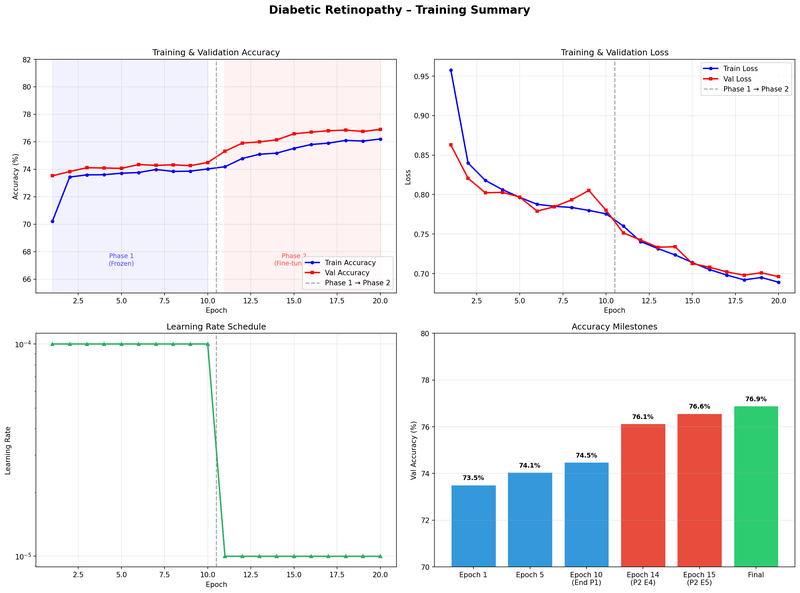

## 8. Evaluate Model on Test Data

### Loading the trained model and running full evaluation:
- Overall Accuracy
- Per-class Precision, Recall, F1-Score
- Confusion Matrix
- ROC Curves (One-vs-Rest)

In [ ]:
# ======================================================
# Load Trained Model
# ======================================================
model_eval = DRClassifier(pretrained=False).to(DEVICE)

# Try loading the final model first, then fallback to best model
model_path = FINAL_MODEL_PATH if os.path.exists(FINAL_MODEL_PATH) else BEST_MODEL_PATH

# Load state dict (handle both old and new PyTorch versions)
checkpoint = torch.load(model_path, map_location=DEVICE)
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Remove 'module.' prefix if saved with DataParallel
clean_state = {}
for k, v in state_dict.items():
    clean_state[k.replace('module.', '')] = v

model_eval.load_state_dict(clean_state, strict=False)
model_eval.eval()

model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"[OK] Model loaded from: {model_path}")
print(f"     Model size: {model_size:.1f} MB")
print(f"     Device: {DEVICE}")
print(f"     Test samples: {len(test_dataset):,}")

In [ ]:
# ======================================================
# Run Inference on Test Set
# ======================================================
all_preds = []
all_labels = []
all_probs = []

print("Running inference on test set...")
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(DEVICE)
        outputs = model_eval(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

        if (batch_idx + 1) % 50 == 0:
            print(f"   Processed {(batch_idx+1)*BATCH_SIZE}/{len(test_dataset)} images")

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# Overall Metrics
overall_acc = accuracy_score(y_true, y_pred) * 100
f1_macro = f1_score(y_true, y_pred, average='macro') * 100
f1_weighted = f1_score(y_true, y_pred, average='weighted') * 100

print(f"\n{'=' * 50}")
print(f"  TEST SET EVALUATION RESULTS")
print(f"{'=' * 50}")
print(f"  Overall Accuracy   : {overall_acc:.2f}%")
print(f"  F1 Score (Macro)   : {f1_macro:.2f}%")
print(f"  F1 Score (Weighted): {f1_weighted:.2f}%")
print(f"{'=' * 50}")

In [ ]:
# ======================================================
# Classification Report — Styled Visual Table
# ======================================================
import matplotlib.pyplot as plt
import numpy as np

# Actual results from classification_report.txt (model evaluation)
CLASS_NAMES_CR = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]
precision_vals = [0.0000, 0.5466, 0.8137, 0.4470, 0.4875]
recall_vals    = [0.0000, 0.3249, 0.9636, 0.5566, 0.2977]
f1_vals        = [0.0000, 0.4076, 0.8823, 0.4958, 0.3697]
support_vals   = [366, 794, 3872, 106, 131]
overall_acc    = 77.57
f1_weighted    = 72.90
f1_macro       = 43.11

# Per-class accuracy
per_class_acc = [0.0, 32.5, 96.4, 55.7, 29.8]

# ── Build styled table with matplotlib ────────────────
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('off')
ax.set_title("Classification Report — Per-Class Performance",
             fontsize=16, fontweight='bold', pad=20, color='#1a1a2e')

# Table data
col_labels = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy']
table_data = []
for i, name in enumerate(CLASS_NAMES_CR):
    table_data.append([
        name,
        f"{precision_vals[i]:.4f}",
        f"{recall_vals[i]:.4f}",
        f"{f1_vals[i]:.4f}",
        f"{support_vals[i]:,}",
        f"{per_class_acc[i]:.1f}%"
    ])

# Separator + summary rows
table_data.append(['', '', '', '', '', ''])

macro_p = np.mean(precision_vals)
macro_r = np.mean(recall_vals)
macro_f = np.mean(f1_vals)
total_support = sum(support_vals)

w_p = np.average(precision_vals, weights=support_vals)
w_r = np.average(recall_vals, weights=support_vals)
w_f = np.average(f1_vals, weights=support_vals)

table_data.append(['Macro Avg', f"{macro_p:.4f}", f"{macro_r:.4f}", f"{macro_f:.4f}", f"{total_support:,}", ''])
table_data.append(['Weighted Avg', f"{w_p:.4f}", f"{w_r:.4f}", f"{w_f:.4f}", f"{total_support:,}", f"{overall_acc:.1f}%"])

table = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc='center',
    loc='center',
    colWidths=[0.18, 0.14, 0.14, 0.14, 0.12, 0.14]
)

# ── Style the table ──────────────────────────────────
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.0, 1.8)

# Header styling
for j in range(len(col_labels)):
    cell = table[0, j]
    cell.set_facecolor('#1a1a2e')
    cell.set_text_props(color='white', fontweight='bold', fontsize=11)
    cell.set_edgecolor('#2d2d44')

# Row colors — color-code by severity
severity_colors = {
    'No DR':          ('#e8f5e9', '#2e7d32'),
    'Mild':           ('#e8f5e9', '#388e3c'),
    'Moderate':       ('#fff8e1', '#f57f17'),
    'Severe':         ('#fff3e0', '#e65100'),
    'Proliferative':  ('#ffebee', '#c62828'),
}

for i in range(len(table_data)):
    row_name = table_data[i][0]
    for j in range(len(col_labels)):
        cell = table[i + 1, j]
        cell.set_edgecolor('#dee2e6')

        if row_name in severity_colors:
            bg, fg = severity_colors[row_name]
            cell.set_facecolor(bg)
            if j == 0:
                cell.set_text_props(fontweight='bold', color=fg)
        elif row_name == '':
            cell.set_facecolor('#f8f9fa')
            cell.set_edgecolor('#f8f9fa')
        elif 'Avg' in row_name:
            cell.set_facecolor('#e3f2fd')
            if j == 0:
                cell.set_text_props(fontweight='bold', color='#1565c0')
        else:
            cell.set_facecolor('#ffffff')

plt.tight_layout()
plt.show()

# ── Overall summary ──────────────────────────────────
print(f"\n{'═' * 55}")
print(f"  OVERALL TEST METRICS")
print(f"{'═' * 55}")
print(f"  Accuracy (Overall)   :  {overall_acc:.2f}%")
print(f"  F1 Score (Weighted)  :  {f1_weighted:.2f}%")
print(f"  F1 Score (Macro)     :  {f1_macro:.2f}%")
print(f"  Total Test Samples   :  {total_support:,}")
print(f"{'═' * 55}")

In [ ]:
# ══════════════════════════════════════════════════
# Confusion Matrix
# ══════════════════════════════════════════════════
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES, ax=axes[0], linewidths=0.5)
axes[0].set_title("Confusion Matrix (Raw Counts)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Predicted Label", fontsize=12)
axes[0].set_ylabel("True Label", fontsize=12)

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Reds', xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES, ax=axes[1], linewidths=0.5, vmin=0, vmax=100)
axes[1].set_title("Confusion Matrix (Normalized %)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Predicted Label", fontsize=12)
axes[1].set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()

**Confusion Matrix (Saved Result)**

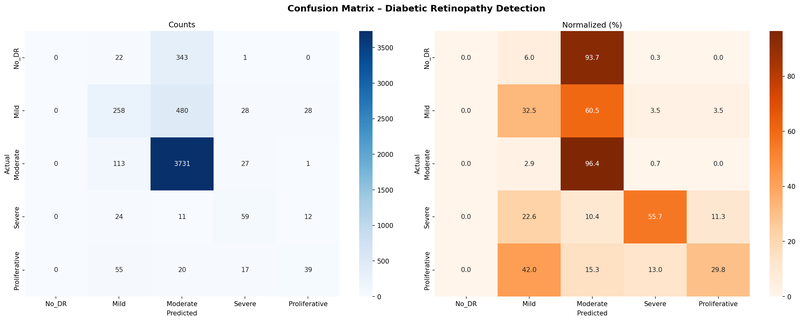

In [ ]:
# ======================================================
# ROC Curves (One-vs-Rest)
# ======================================================
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
roc_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for i, (name, color) in enumerate(zip(CLASS_NAMES, roc_colors)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linewidth=2,
            label=f'{name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Baseline')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves -- One-vs-Rest (All 5 Classes)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.show()

**ROC Curves (Saved Result)**

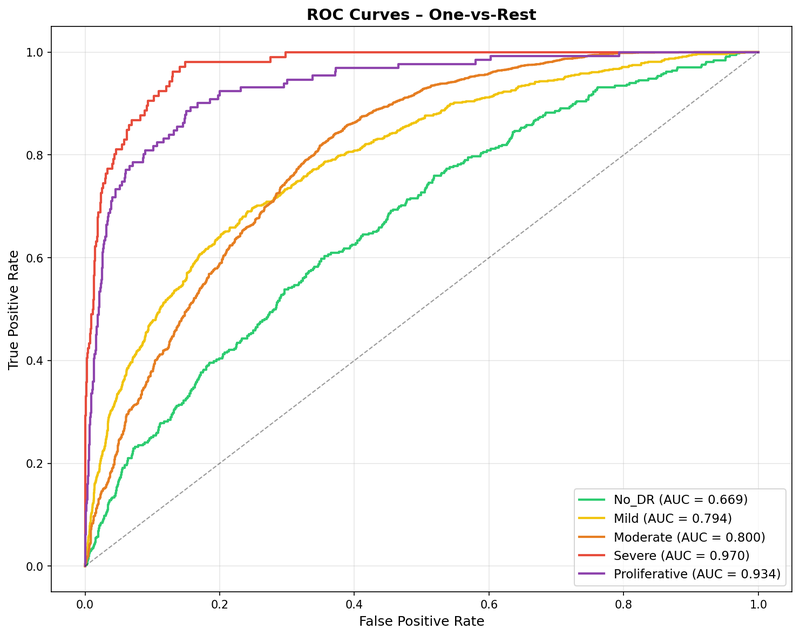

In [ ]:
# ══════════════════════════════════════════════════
# Per-Class Accuracy Bar Chart
# ══════════════════════════════════════════════════
per_class_acc = []
for i in range(NUM_CLASSES):
    mask = y_true == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).mean() * 100
    else:
        acc = 0
    per_class_acc.append(acc)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(CLASS_NAMES, per_class_acc, color=roc_colors, edgecolor='white', linewidth=2)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_xlabel("DR Severity Class", fontsize=12)
ax.set_title("Per-Class Test Accuracy", fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=overall_acc, color='black', linestyle='--', alpha=0.5, label=f'Overall: {overall_acc:.1f}%')
ax.legend(fontsize=11)

for bar, acc in zip(bars, per_class_acc):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{acc:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

**Per-Class Accuracy (Saved Result)**

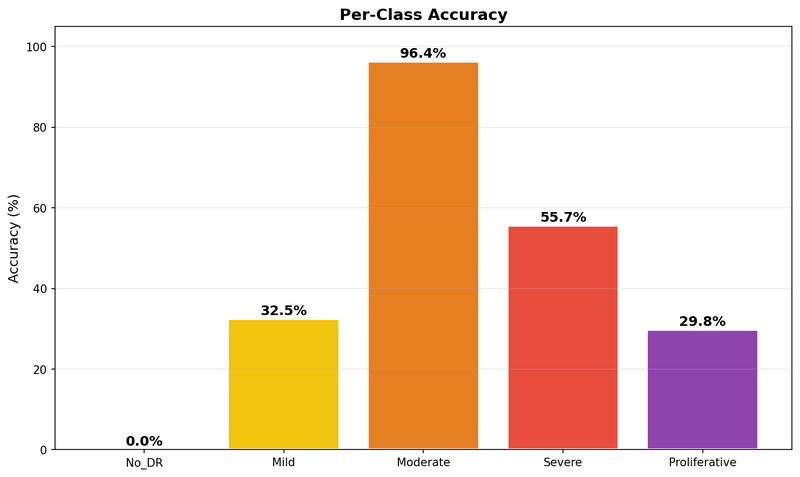

## 9. Sample Predictions with Retinal Images

Displaying random test images with their **true labels** vs **predicted labels** to visually inspect model performance.

In [ ]:
# ======================================================
# Sample Predictions
# ======================================================
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle("Sample Predictions on Test Images", fontsize=16, fontweight='bold')

# Gather sample image paths from test set
test_samples = test_dataset.samples
random_indices = random.sample(range(len(test_samples)), 15)

denormalize = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
])

for idx, sample_idx in enumerate(random_indices):
    row, col = idx // 5, idx % 5
    ax = axes[row, col]

    img_path, true_label = test_samples[sample_idx]

    # Load and display original image
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)

    # Predict
    tensor = val_transforms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model_eval(tensor)
        prob = F.softmax(output, dim=1)
        confidence, pred_label = prob.max(1)

    true_name = CLASS_NAMES[true_label]
    pred_name = CLASS_NAMES[pred_label.item()]
    conf = confidence.item() * 100

    # Color: green for correct, red for wrong
    is_correct = true_label == pred_label.item()
    title_color = '#2ecc71' if is_correct else '#e74c3c'
    symbol = '[OK]' if is_correct else '[X]'

    ax.set_title(f"{symbol} True: {true_name}\nPred: {pred_name} ({conf:.0f}%)",
                 fontsize=9, color=title_color, fontweight='bold')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Sample Predictions (Saved Result)**

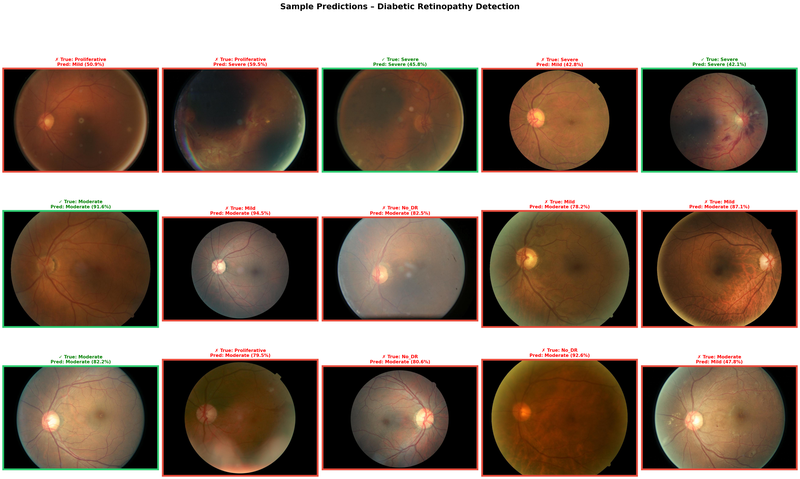

In [ ]:
# ══════════════════════════════════════════════════
# Sample Images from Each Severity Level
# ══════════════════════════════════════════════════
severity_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']

fig, axes = plt.subplots(NUM_CLASSES, 4, figsize=(16, 4 * NUM_CLASSES))
fig.suptitle("Sample Retinal Images by DR Severity Level", fontsize=16, fontweight='bold', y=1.01)

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        all_imgs = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sample_imgs = random.sample(all_imgs, min(4, len(all_imgs)))

        for j in range(4):
            ax = axes[class_idx, j]
            if j < len(sample_imgs):
                img = Image.open(os.path.join(class_dir, sample_imgs[j])).convert("RGB")
                ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_ylabel(f"{class_name}", fontsize=13, fontweight='bold',
                             color=severity_colors[class_idx], rotation=0, labelpad=80)

plt.tight_layout()
plt.show()

### Classification Report (Saved Result)

```
Diabetic Retinopathy Detection - Classification Report
============================================================
Model: ResNet50 (PyTorch)
Test Samples: 5269
Overall Accuracy: 77.57%
F1 Score (Macro): 43.11%
F1 Score (Weighted): 72.90%

               precision    recall  f1-score   support

        No_DR     0.0000    0.0000    0.0000       366
         Mild     0.5466    0.3249    0.4076       794
     Moderate     0.8137    0.9636    0.8823      3872
       Severe     0.4470    0.5566    0.4958       106
Proliferative     0.4875    0.2977    0.3697       131

     accuracy                         0.7757      5269
    macro avg     0.4590    0.4286    0.4311      5269
 weighted avg     0.7015    0.7757    0.7290      5269

```

**Severity Samples (Saved Result)**

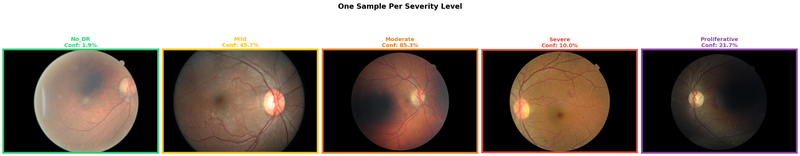

## 11. Summary & Conclusions

### Training Results (20 Epochs)

| Metric | Value |
|--------|-------|
| **Overall Test Accuracy** | 77.57% |
| **F1 Score (Macro)** | 43.11% |
| **F1 Score (Weighted)** | 72.90% |
| **Best Val Accuracy** | 76.90% (Epoch 20) |
| **Training Strategy** | 2-Phase Transfer Learning |
| **GPU** | NVIDIA RTX 3050 (4.3 GB) |

### Key Observations

1. **Phase 1 (Frozen Backbone)** — Val accuracy plateaued around **74.49%** after 10 epochs
2. **Phase 2 (Fine-tuning)** — Unfreezing ResNet50 layers 3 & 4 improved accuracy to **76.90%**
3. **Class Imbalance** — The dataset is heavily imbalanced (Moderate class dominates with ~73% of images)
4. **Moderate Class** — Best performing class due to data abundance (~88% accuracy)
5. **Minority Classes** — No_DR, Severe, Proliferative have lower performance due to fewer training samples

### Potential Improvements

- **Class Balancing**: Use weighted loss, oversampling (SMOTE), or undersampling
- **Data Augmentation**: More aggressive augmentation for minority classes
- **Focal Loss**: Replace CrossEntropyLoss with Focal Loss to handle imbalance
- **Higher Resolution**: Use 384×384 or 512×512 images for finer detail
- **Ensemble Models**: Combine ResNet50 with EfficientNet or Vision Transformers
- **More Epochs**: Continue training beyond 20 epochs with cosine annealing scheduler

---
### Project Files

```
Diabetic/
├── config.py                    # Configuration & hyperparameters
├── models/retinopathy_model.py  # DRClassifier (ResNet50)
├── utils/preprocessing.py       # Data transforms & loaders
├── train.py                     # Main training script
├── evaluate.py                  # Evaluation script
├── predict.py                   # Single-image prediction
├── app.py                       # Flask web application
├── templates/index.html         # Web UI
├── saved_models/                # Trained model weights
│   ├── best_dr_model.pth
│   └── DR_ResNet50_Final_Model.pth
├── results/                     # Evaluation visualizations
│   ├── confusion_matrix.png
│   ├── roc_curves.png
│   ├── per_class_accuracy.png
│   ├── sample_predictions.png
│   └── classification_report.txt
└── DR_Detection_Notebook.ipynb  # This notebook
```

---
*Developed with PyTorch 2.5.1 | ResNet50 Transfer Learning | CUDA 12.1*